In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix,roc_auc_score,roc_curve
import scipy.stats as stats
from matplotlib import pylab

In [2]:
df = pd.read_csv('diabetes.csv')
df

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1
...,...,...,...,...,...,...,...,...,...
763,10,101,76,48,180,32.9,0.171,63,0
764,2,122,70,27,0,36.8,0.340,27,0
765,5,121,72,23,112,26.2,0.245,30,0
766,1,126,60,0,0,30.1,0.349,47,1


In [3]:
df['Outcome'].value_counts()

0    500
1    268
Name: Outcome, dtype: int64

In [4]:
df.isnull().sum()

Pregnancies                 0
Glucose                     0
BloodPressure               0
SkinThickness               0
Insulin                     0
BMI                         0
DiabetesPedigreeFunction    0
Age                         0
Outcome                     0
dtype: int64

#### Fixing the data into Normal Distribution

In [5]:
def diagnostic_plots(df, variable):
    
    plt.figure(figsize=(15,6))
    plt.subplot(1, 2, 1)
    df[variable].hist()

    plt.subplot(1, 2, 2)
    stats.probplot(df[variable], dist="norm", plot=pylab)

    plt.show()

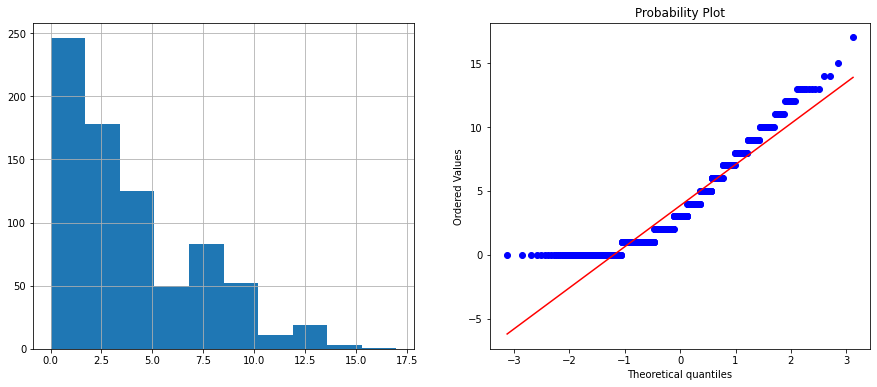

In [6]:
diagnostic_plots(df, 'Pregnancies')

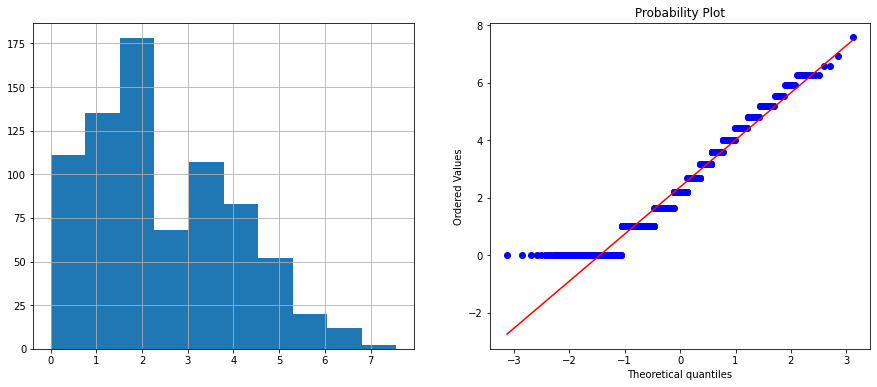

In [7]:
df['Pregnancies'] = df.Pregnancies**(1/1.4)

diagnostic_plots(df, 'Pregnancies')

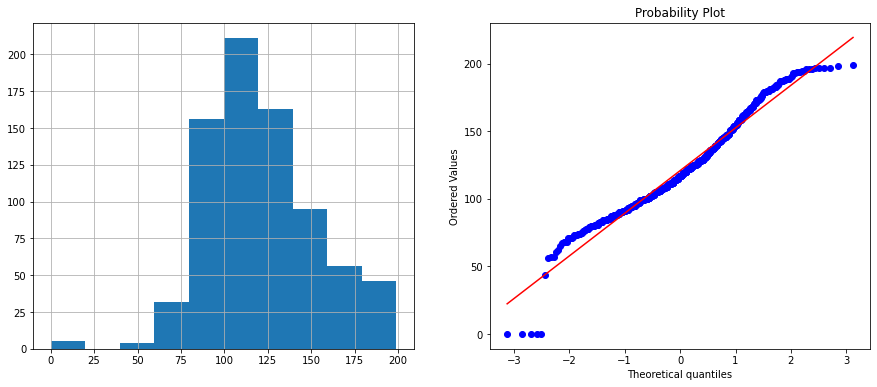

In [8]:
diagnostic_plots(df, 'Glucose')

df['Glucose_log'] = df.Glucose**(0.95)

diagnostic_plots(df, 'Glucose_log')

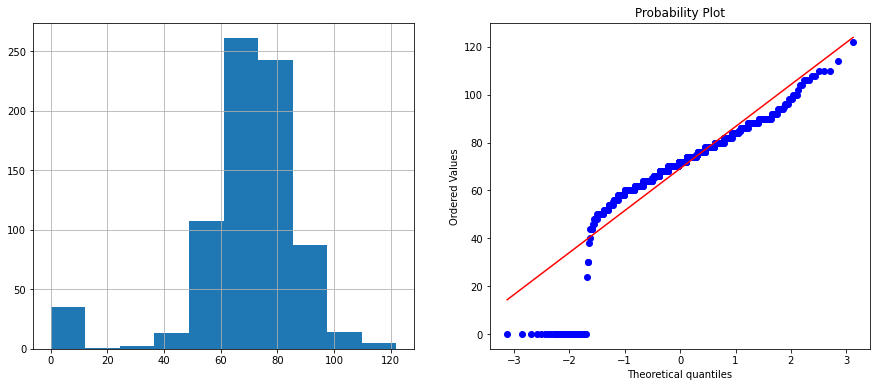

In [9]:
diagnostic_plots(df, 'BloodPressure')

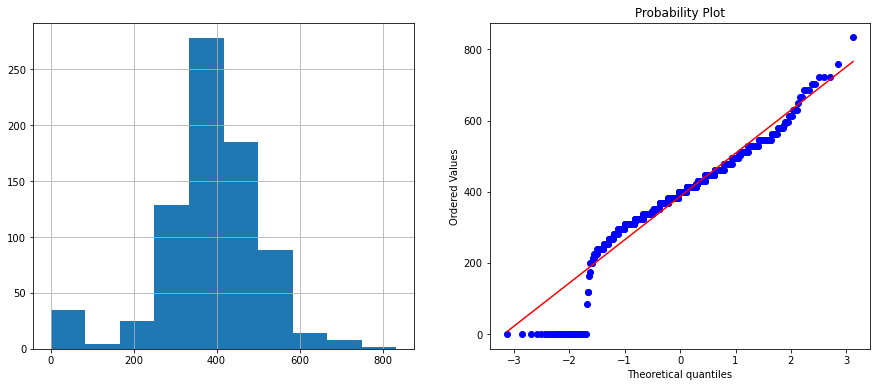

In [10]:
df['BloodPressure'] = df.BloodPressure**1.4

diagnostic_plots(df, 'BloodPressure')

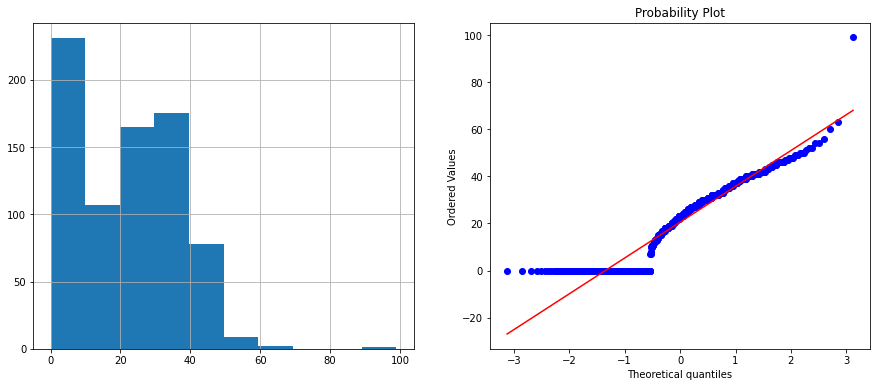

In [11]:
diagnostic_plots(df, 'SkinThickness')

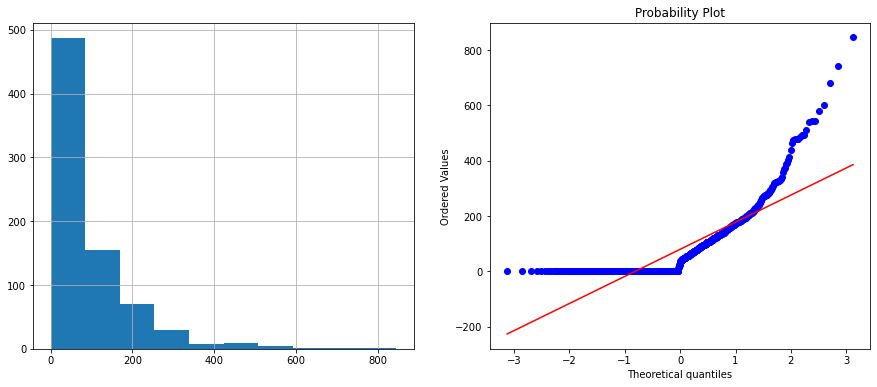

In [12]:
diagnostic_plots(df, 'Insulin')

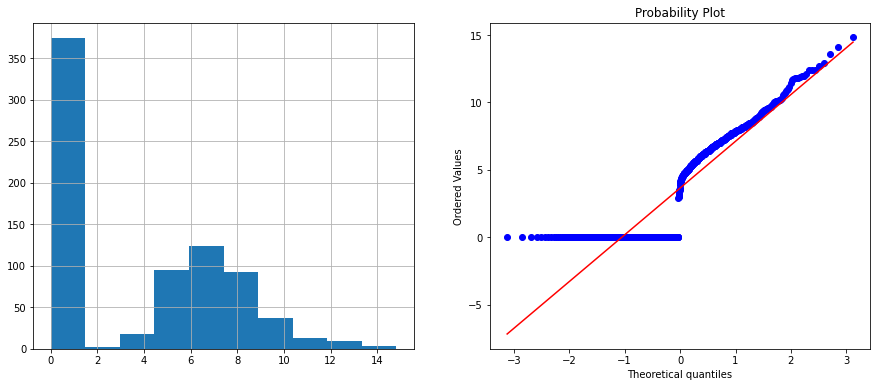

In [13]:
df['Insulin'] = df.Insulin**0.4

diagnostic_plots(df, 'Insulin')

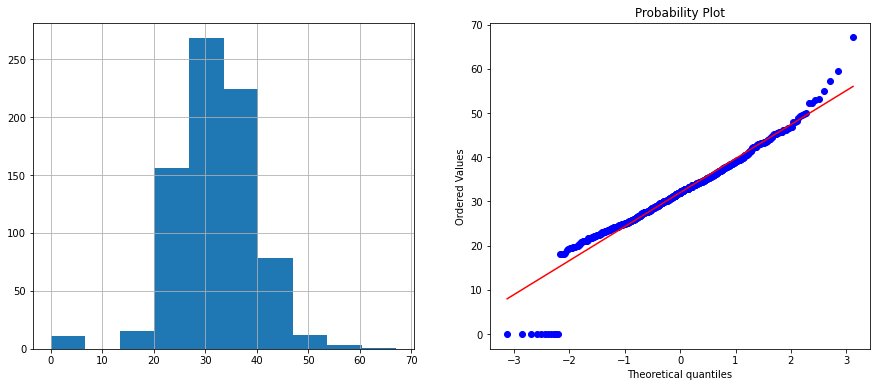

In [14]:
diagnostic_plots(df, 'BMI')

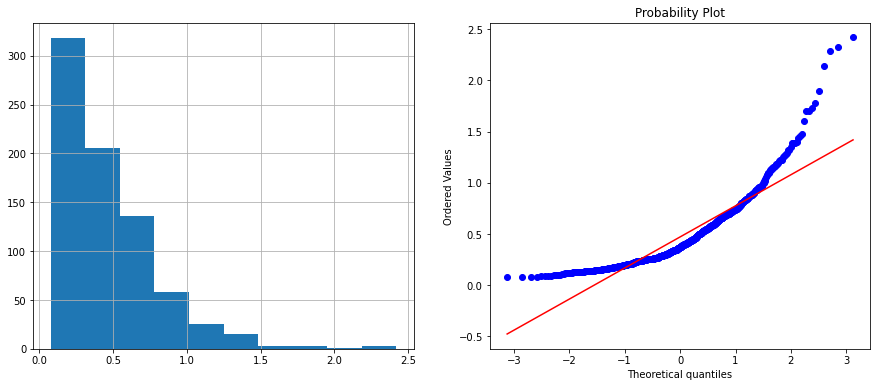

In [15]:
diagnostic_plots(df, 'DiabetesPedigreeFunction')

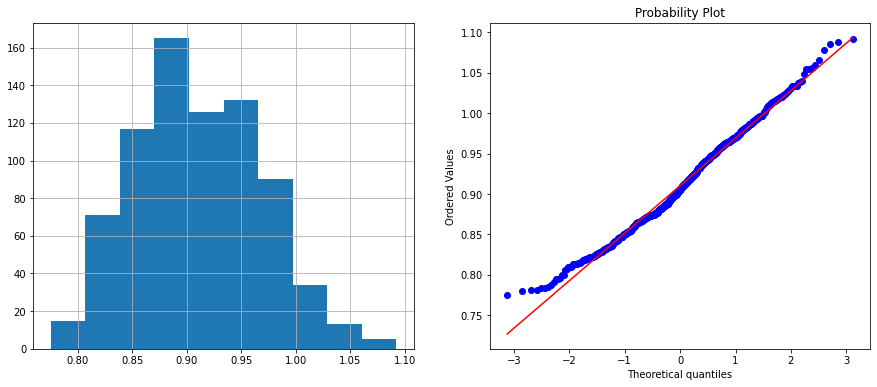

In [16]:
df['DiabetesPedigreeFunction'] = df.DiabetesPedigreeFunction**0.1

diagnostic_plots(df, 'DiabetesPedigreeFunction')

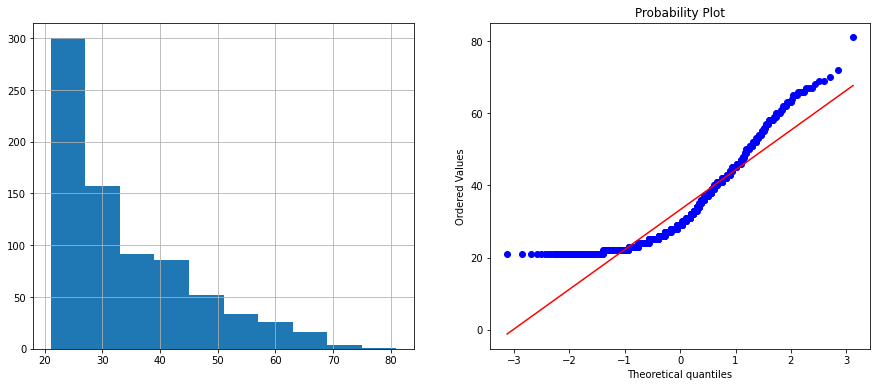

In [17]:
diagnostic_plots(df, 'Age')

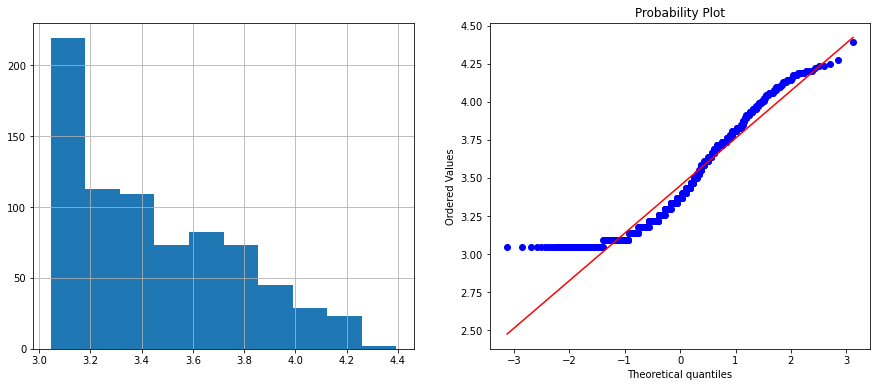

In [18]:
df['Age']= np.log(df.Age)

diagnostic_plots(df, 'Age')

#### Removing Outliers

In [19]:
for feature in df.columns[:-1]:
    IQR = df[feature].quantile(0.75) - df[feature].quantile(0.25)
    upper_bond = df[feature].quantile(0.75) + (IQR * 1.5)
    lower_bond = df[feature].quantile(0.25) - (IQR * 1.5)
    
    df[feature] = np.where(df[feature]>upper_bond,upper_bond,df[feature])
    df[feature] = np.where(df[feature]<lower_bond,lower_bond,df[feature])
    

#### Capturing NaN Value with Extra Variable and Imputating the NaN

In [20]:
for feature in df.columns[:-1]:
    df[f'{feature}_zero'] = np.where(df[feature]==0,1,0)
    df[feature] = np.where((df[feature]==0) & (df['Outcome']==0),df.groupby('Outcome')[feature].median()[0],df[feature])
    df[feature] = np.where((df[feature]==0) & (df['Outcome']==1),df.groupby('Outcome')[feature].median()[1],df[feature])

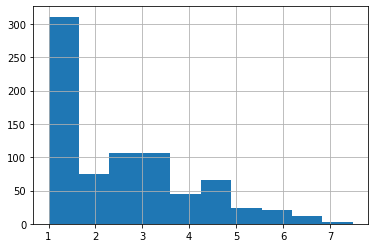

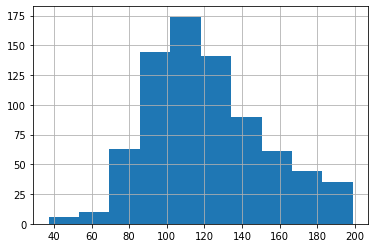

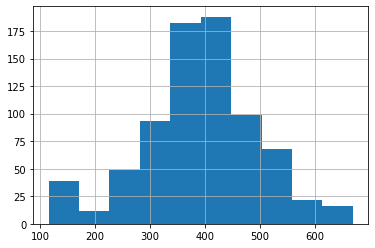

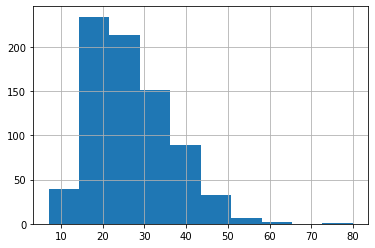

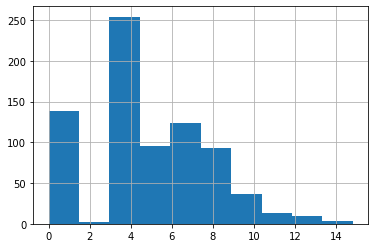

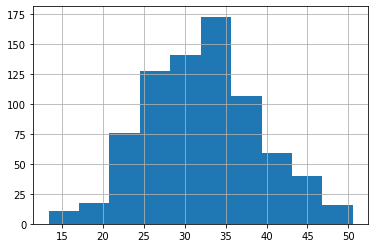

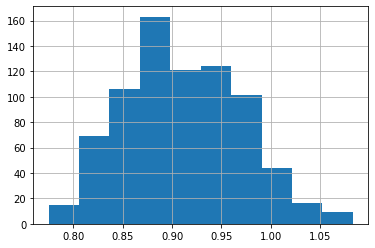

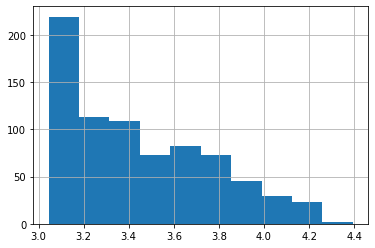

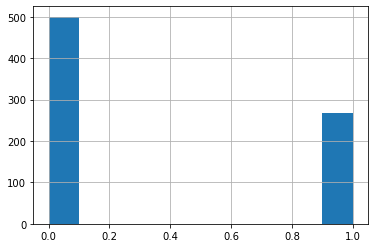

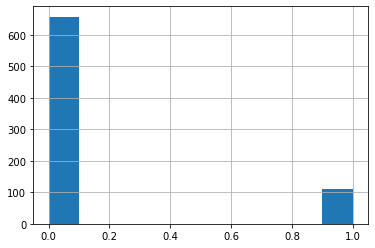

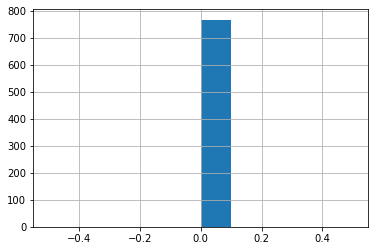

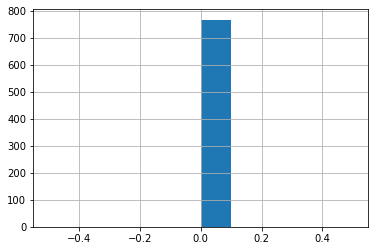

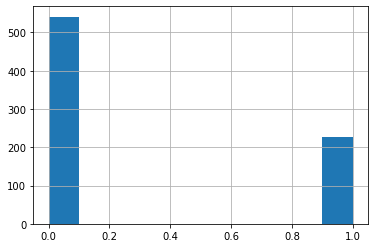

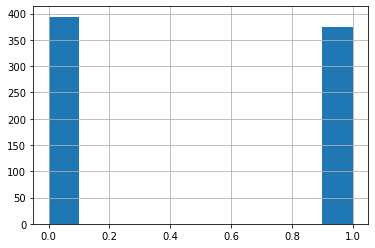

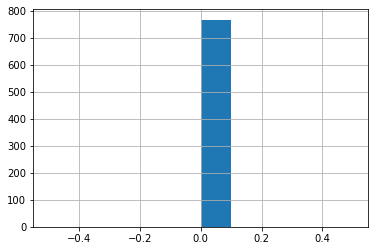

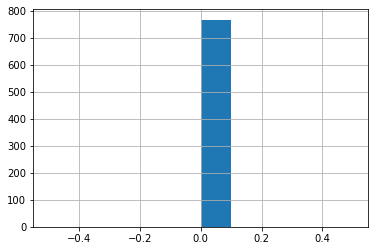

In [21]:
for feature in df.columns[:-1]:
    df[feature].hist()
    plt.show()

In [22]:
X = df.drop('Outcome', axis=1)
X = StandardScaler().fit_transform(X)
y = df['Outcome']

In [23]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=0)

In [24]:
y_train.value_counts()

0    370
1    206
Name: Outcome, dtype: int64

In [25]:
y_test.value_counts()

0    130
1     62
Name: Outcome, dtype: int64

In [26]:
model = SVC()

parameters = [{'kernel': ['rbf'],
               
               'gamma': [1e-3, 1e-4],
               
               'C': [1, 10, 100, 1000]}]

In [27]:
grid = GridSearchCV(estimator=model, param_grid=parameters, cv=5,scoring='roc_auc')
grid.fit(X, y)

GridSearchCV(cv=5, error_score=nan,
             estimator=SVC(C=1.0, break_ties=False, cache_size=200,
                           class_weight=None, coef0=0.0,
                           decision_function_shape='ovr', degree=3,
                           gamma='scale', kernel='rbf', max_iter=-1,
                           probability=False, random_state=None, shrinking=True,
                           tol=0.001, verbose=False),
             iid='deprecated', n_jobs=None,
             param_grid=[{'C': [1, 10, 100, 1000], 'gamma': [0.001, 0.0001],
                          'kernel': ['rbf']}],
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring='roc_auc', verbose=0)

In [28]:
grid.best_estimator_

SVC(C=1000, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma=0.001, kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

In [29]:
roc_auc = np.around(np.mean(cross_val_score(grid, X, y, cv=5, scoring='roc_auc')), decimals=4)
print('Score: {}'.format(roc_auc))

Score: 0.9389


#### 0.9389 roc_auc score by cross_val_score

#### Testing on Test data

In [30]:
model = SVC(C=1000, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma=0.001, kernel='rbf',
    max_iter=-1, probability=True, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

In [31]:
model.fit(X_train,y_train)

SVC(C=1000, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma=0.001, kernel='rbf',
    max_iter=-1, probability=True, random_state=None, shrinking=True, tol=0.001,
    verbose=False)

In [32]:
y_predicted = model.predict(X_test)

In [33]:
y_pred_proba = model.predict_proba(X_test)

In [34]:
print(classification_report(y_test, y_predicted))

              precision    recall  f1-score   support

           0       0.92      0.95      0.94       130
           1       0.88      0.84      0.86        62

    accuracy                           0.91       192
   macro avg       0.90      0.89      0.90       192
weighted avg       0.91      0.91      0.91       192



In [35]:
print(confusion_matrix(y_test, y_predicted))

[[123   7]
 [ 10  52]]


In [36]:
roc_auc_score(y_test,y_predicted)

0.8924317617866006

#### roc_auc_score of X_test is 0.8924

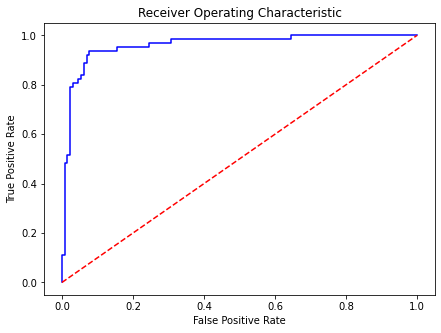

In [37]:
plt.figure(figsize=(7,5))
fpr, tpr, thresh = roc_curve(y_test, y_pred_proba[:,1])
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr,color='blue')
plt.plot([0, 1], [0, 1],'r--')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()
